In [ ]:
!pip install googlesearch-python

  Preparing metadata (setup.py) ... done
  Created wheel for googlesearch-python: filename=googlesearch_python-1.2.3-py3-none-any.whl size=4204 sha256=b4d1f9805dc98f79605c2f149872818ec8e6cacf918a097e765ae5c60dad4e18
  Stored in directory: /root/.cache/pip/wheels/98/24/e9/6c225502948c629b01cc895f86406819281ef0da385f3eb669
Successfully built googlesearch-python


In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
df=pd.read_csv('/content/malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

benign        428101
defacement     96455
phishing       94111
malware        32520
end                4
Name: type, dtype: int64

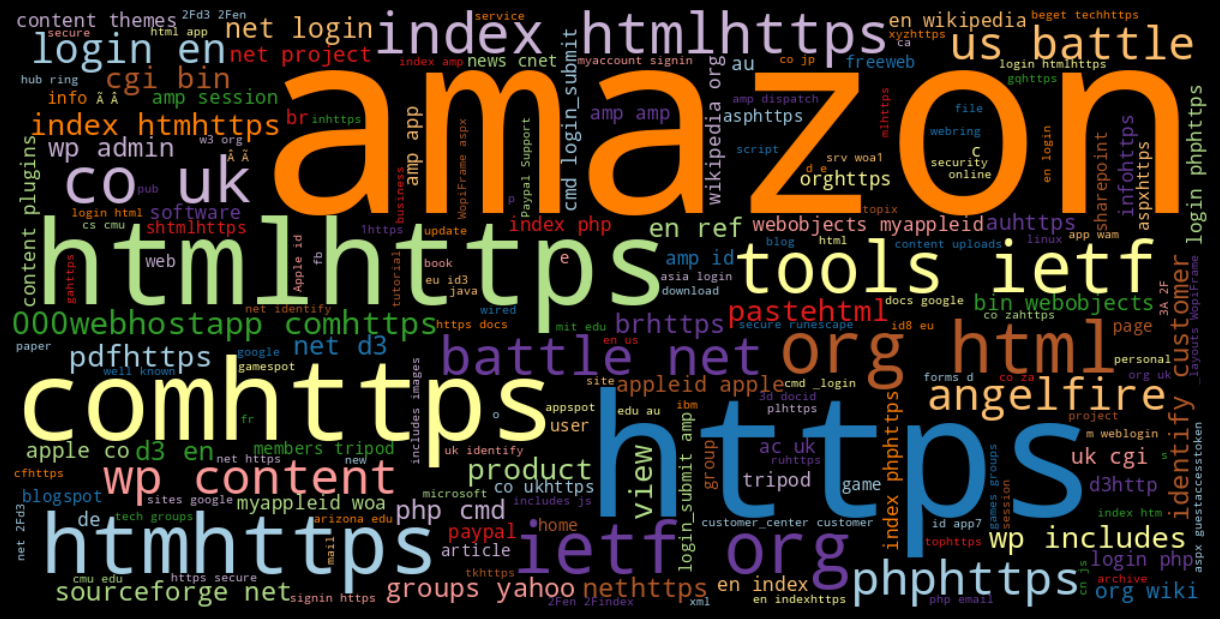

In [ ]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']


phish_url = "https://www.amazon.in/".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1000, height=500,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

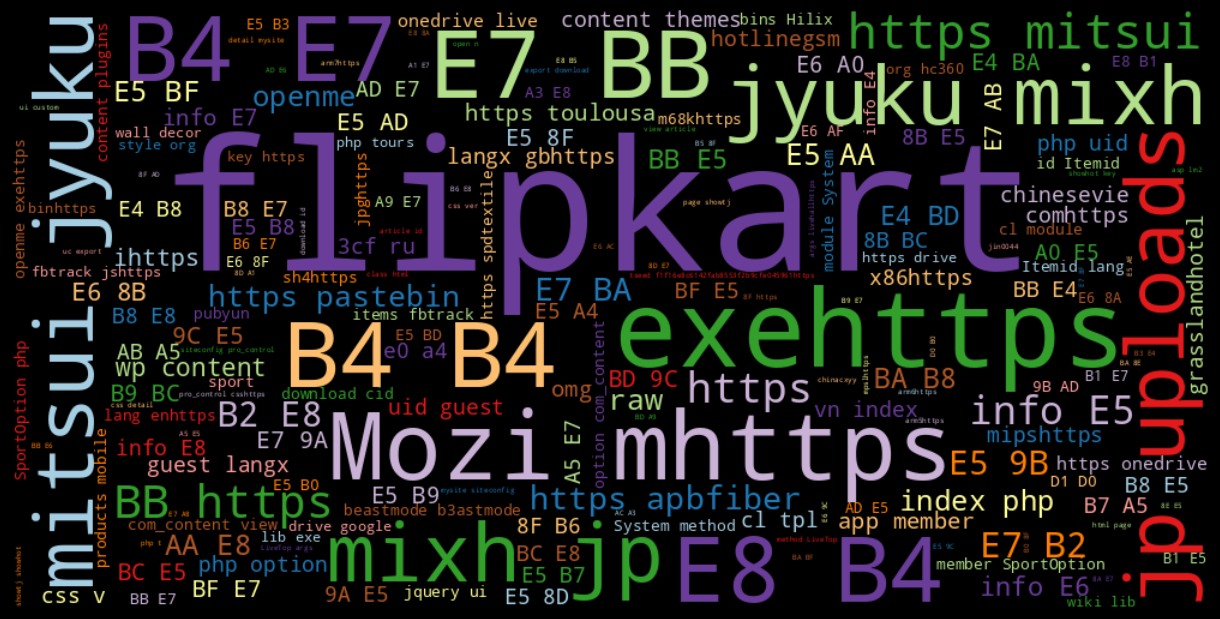

In [ ]:
malware_url = "https://www.flipkart.com/".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1000, height=500,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

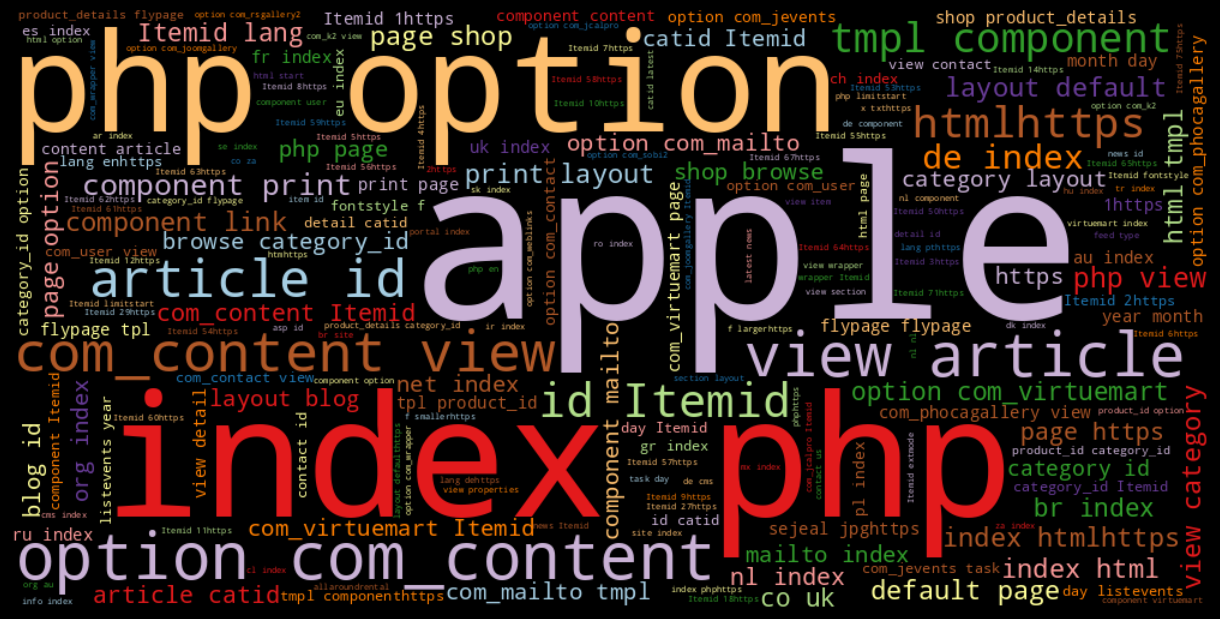

In [ ]:
deface_url = "https://www.apple.com/in/".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1000, height=500,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

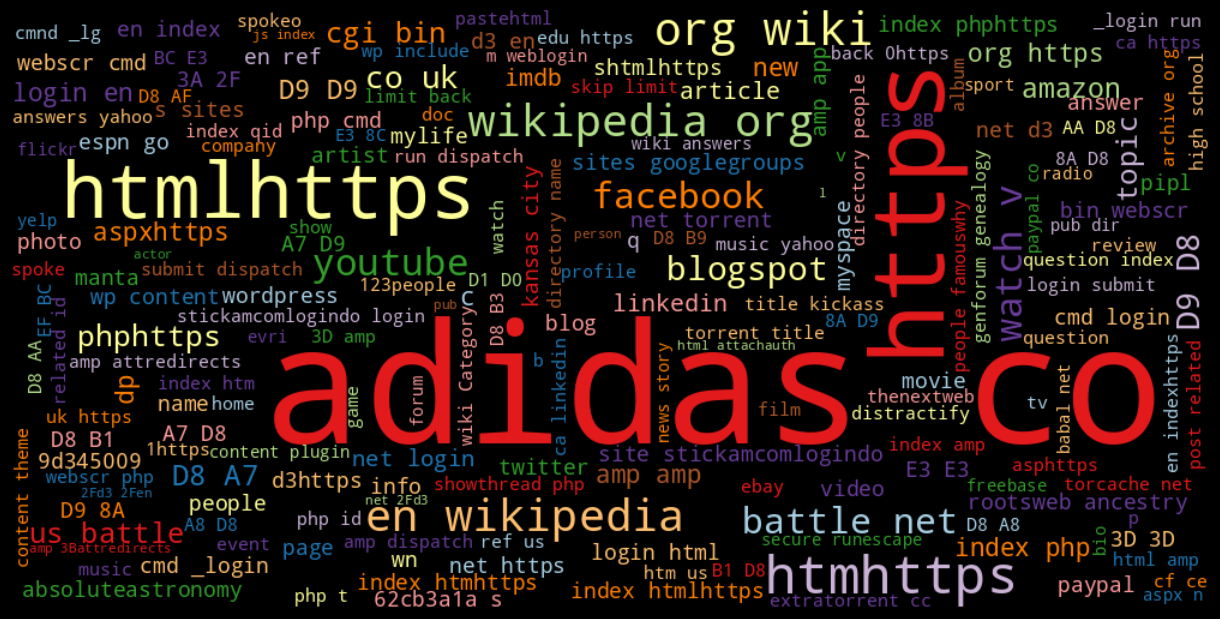

In [ ]:
benign_url = "https://www.adidas.co.in/".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1000, height=500,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
import re
#Checking if the domain contains the IP
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [ ]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [ ]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [ ]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [ ]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL

df['url_length'] = df['url'].apply(lambda i: url_length(i))

#Hostname Length
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()


,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [ ]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [ ]:
df = df.drop("tld",1)
df.columns

<ipython-input-16-a3c3578d9666>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [ ]:
df['type'].value_counts()

benign        428101
defacement     96455
phishing       94111
malware        32520
end                4
Name: type, dtype: int64

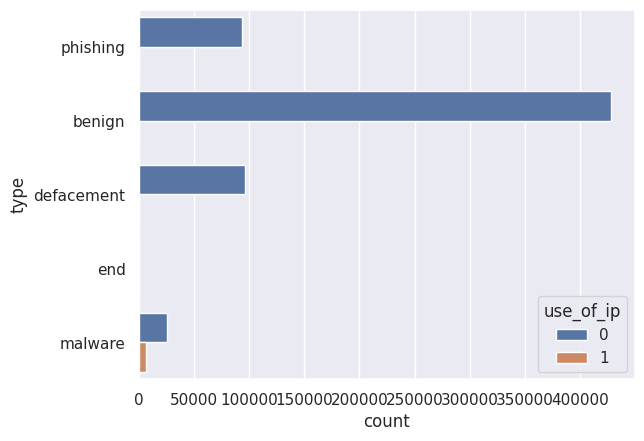

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

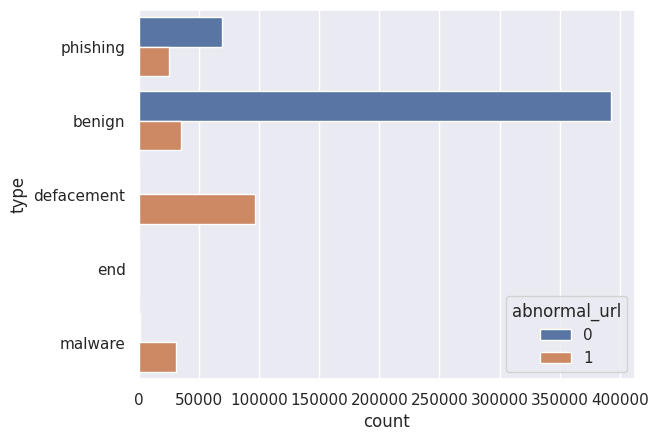

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

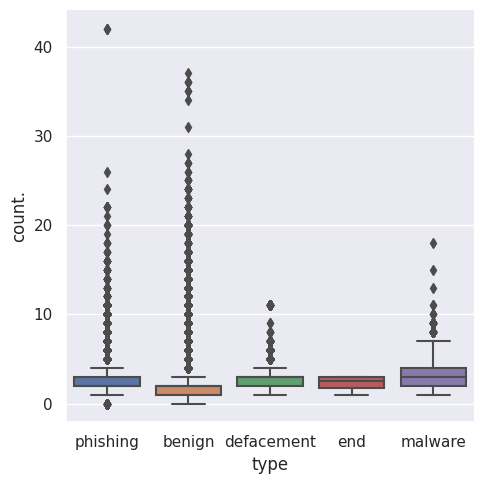

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

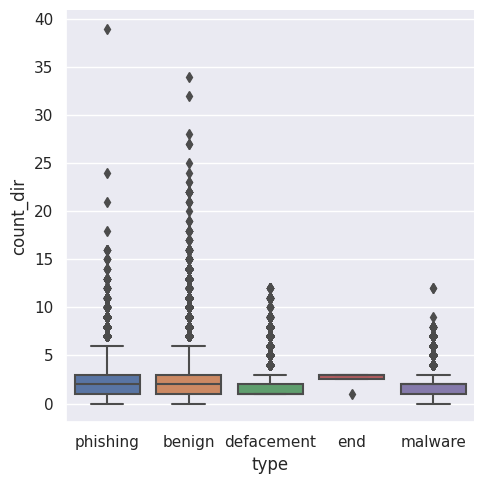

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428101
1     96455
4     94111
3     32520
2         4
Name: type_code, dtype: int64

In [ ]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

In [ ]:
y = df['type_code']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware','end']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85777
  defacement       0.98      0.99      0.99     19104
    phishing       0.00      0.00      0.00         1
     malware       0.99      0.94      0.96      6521
         end       0.91      0.87      0.89     18836

    accuracy                           0.97    130239
   macro avg       0.77      0.76      0.76    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


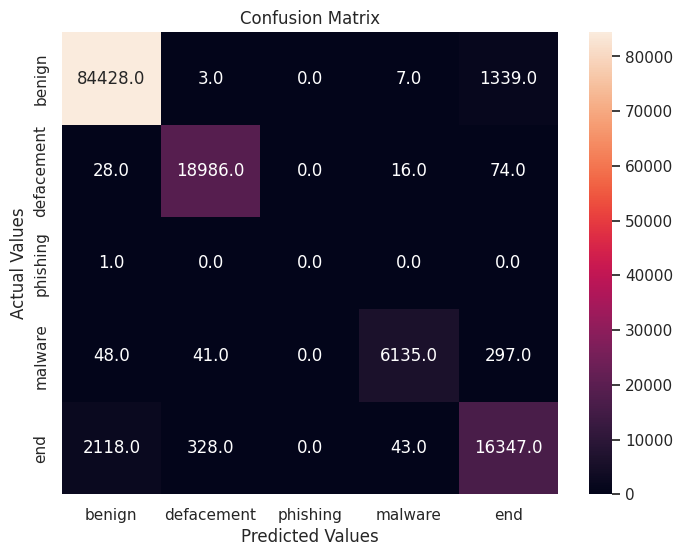

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware','end'],
                     columns = ['benign', 'defacement','phishing','malware','end'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

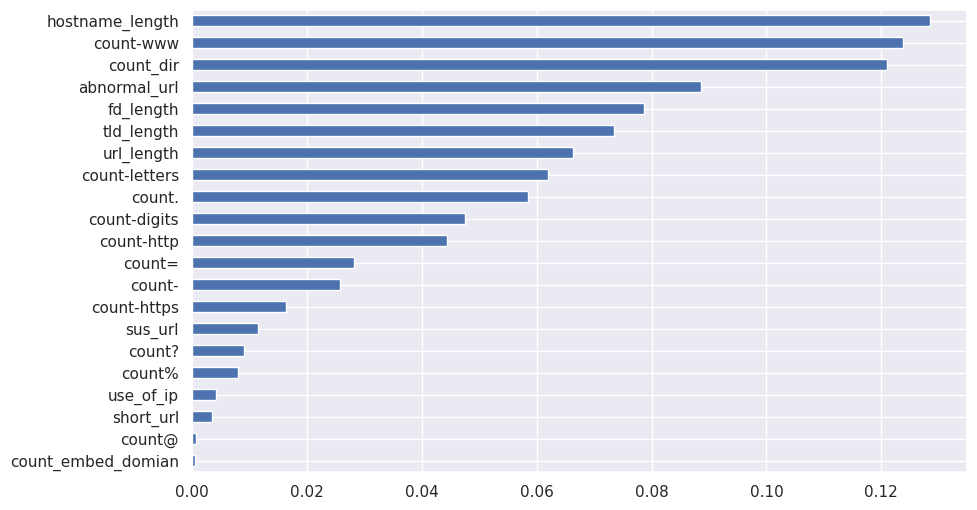

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))
plt.show()

In [ ]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware','end']))

score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85777
  defacement       0.97      0.99      0.98     19104
    phishing       0.00      0.00      0.00         1
     malware       0.98      0.92      0.95      6521
         end       0.91      0.84      0.87     18836

    accuracy                           0.96    130239
   macro avg       0.77      0.75      0.76    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


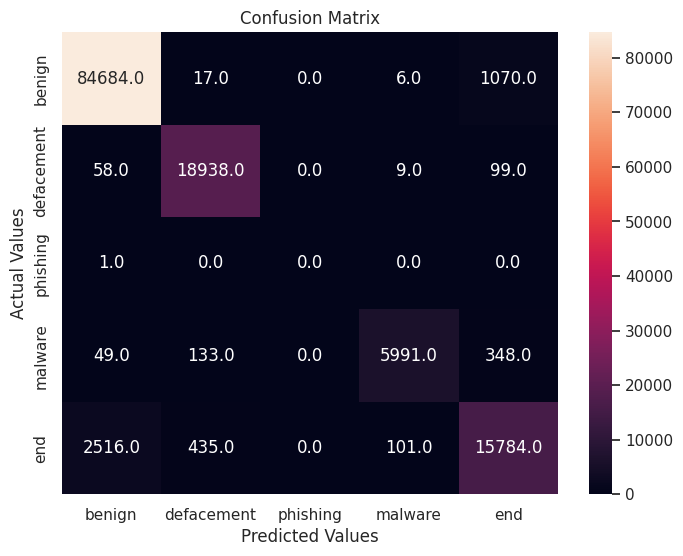

In [ ]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware','end'],
                     columns = ['benign', 'defacement','phishing','malware','end'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

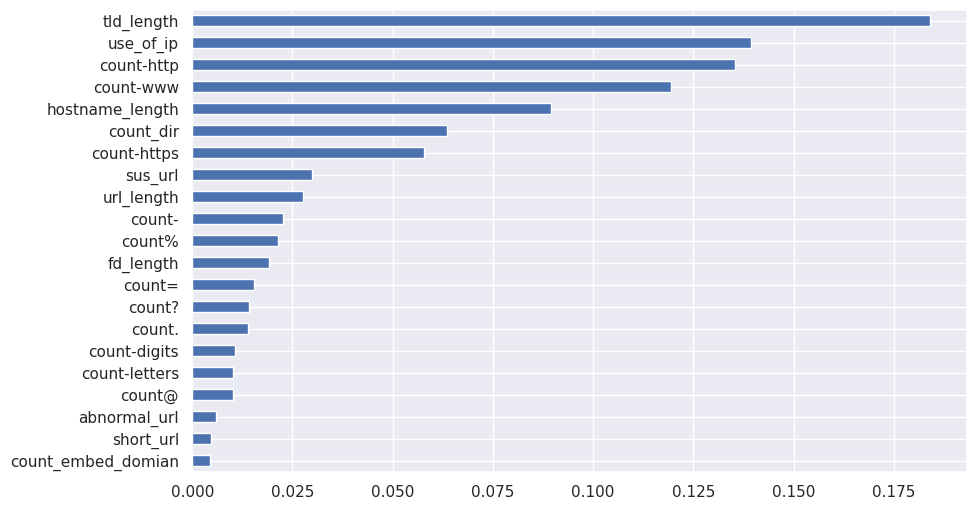

In [ ]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))
plt.show()


In [ ]:
def main(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))

    return status

In [ ]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = lgb.predict(features_test)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res

In [ ]:
# CNN CODE

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Load your dataset (Assuming you have a CSV file with 'url' and 'label' columns)
data = pd.read_csv('/content/data.csv')
X = data['url'].values
y = data['label'].values

# Tokenize the URLs
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to a fixed length
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Construct the CNN model and define it as 'model'
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          18944     
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                      

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Construct the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)


Epoch 1/3
750/750 [==============================] - 38s 50ms/step - loss: 0.1943 - accuracy: 0.9419 - val_loss: 0.0623 - val_accuracy: 0.9823
Epoch 2/3
750/750 [==============================] - 39s 52ms/step - loss: 0.0561 - accuracy: 0.9824 - val_loss: 0.0533 - val_accuracy: 0.9843
Epoch 3/3
750/750 [==============================] - 38s 51ms/step - loss: 0.0392 - accuracy: 0.9881 - val_loss: 0.0458 - val_accuracy: 0.9871


In [ ]:
# Evaluate the model and find accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

313/313 [==============================] - 3s 8ms/step - loss: 0.0375 - accuracy: 0.9876
Test Accuracy: 98.76%


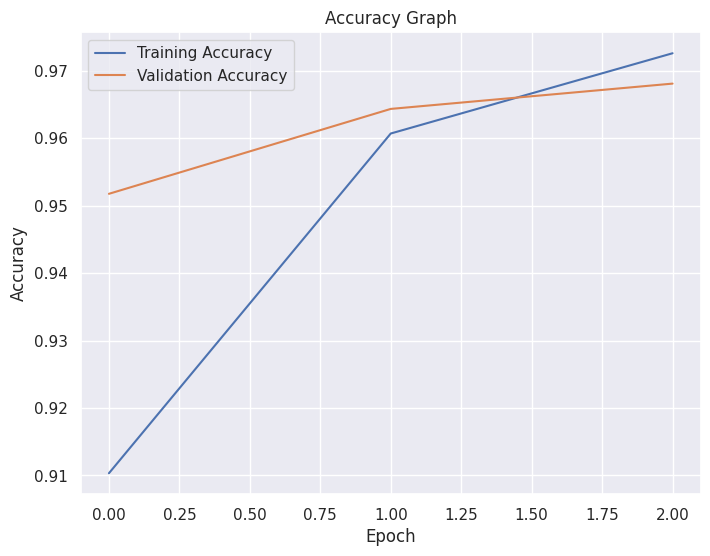

In [ ]:
# Plot accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')
plt.show()

In [ ]:
#DCNN CODE

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Load your dataset (Assuming you have a CSV file with 'url' and 'label' columns)
data = pd.read_csv('/content/data.csv')
X = data['url'].values
y = data['label'].values

# Tokenize the URLs
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to a fixed length
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Construct the DCNN model and define it as 'model'
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          18944     
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 conv1d_4 (Conv1D)           (None, 92, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                      

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Construct the DCNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))  # Corrected the missing parenthesis
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/3
750/750 [==============================] - 48s 60ms/step - loss: 0.1958 - accuracy: 0.9413 - val_loss: 0.0786 - val_accuracy: 0.9766
Epoch 2/3
750/750 [==============================] - 46s 62ms/step - loss: 0.0588 - accuracy: 0.9820 - val_loss: 0.0533 - val_accuracy: 0.9830
Epoch 3/3
313/313 [==============================] - 4s 12ms/step - loss: 0.0443 - accuracy: 0.9846
Test Accuracy: 98.46%


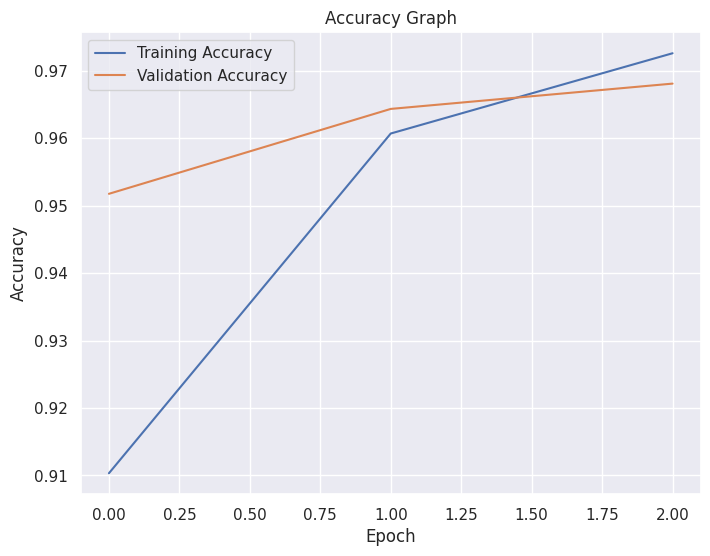

In [ ]:
# Plot accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')
plt.show()

In [ ]:
#DFCNN CODE

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv2D, GlobalMaxPooling2D, Dense, Dropout

# Load your dataset (Assuming you have a CSV file with 'url' and 'label' columns)
data = pd.read_csv('/content/data.csv')
X = data['url'].values
y = data['label'].values

# Tokenize the URLs
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to a fixed length
max_sequence_length = 100
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


In [ ]:
# Construct the DFCNN model and define it as 'model'
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 128)          18944     
                                                                 
 dense_23 (Dense)            (None, 100, 64)           8256      
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_24 (Dense)            (None, 100, 1)            65        
                                                                 
Total params: 27265 (106.50 KB)
Trainable params: 27265 (106.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Construct the DFCNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Evaluate the model and find accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/3
750/750 [==============================] - 149s 196ms/step - loss: 0.8175 - accuracy: 0.7372 - val_loss: 0.2894 - val_accuracy: 0.9178
Epoch 2/3
750/750 [==============================] - 144s 192ms/step - loss: 0.2617 - accuracy: 0.9232 - val_loss: 0.2106 - val_accuracy: 0.9351
Epoch 3/3
313/313 [==============================] - 8s 25ms/step - loss: 0.1504 - accuracy: 0.9571
Test Accuracy: 95.71%


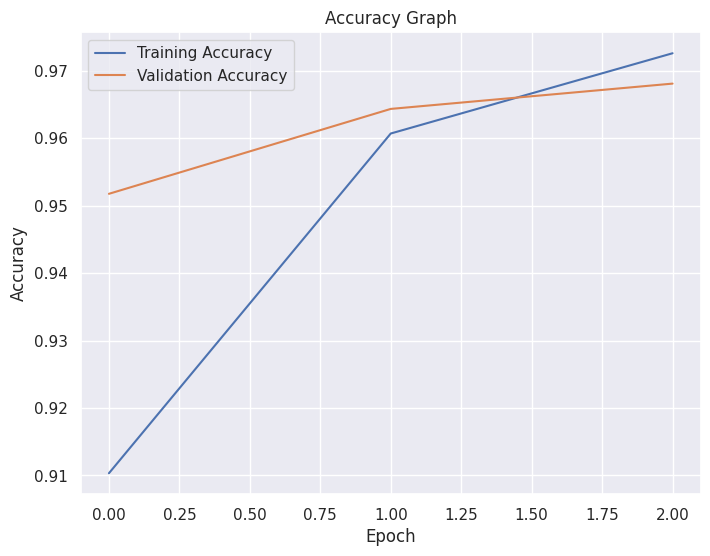

In [ ]:
# Plot accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')
plt.show()

In [ ]:
#SmDFCNN CODE

In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 26.4 MB/s eta 0:00:00


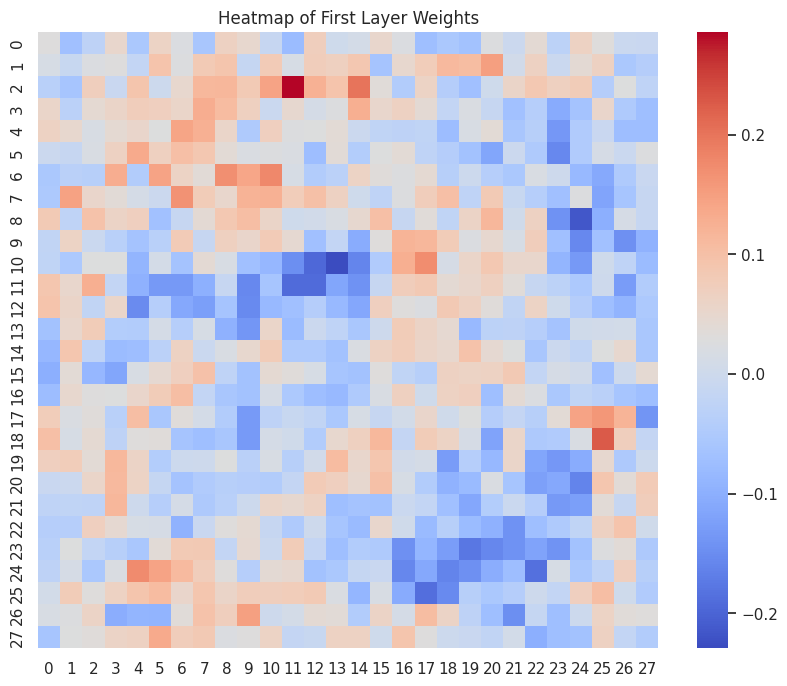

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout

# RDKit for processing SMILES
from rdkit.Chem import AllChem

# Load your dataset (Assuming you have a CSV file with 'url' and 'label' columns)
data = pd.read_csv('/content/data.csv')
x = data['url'].values
y = data['label'].values

import matplotlib.pyplot as plt
import seaborn as sns

# Get the weights of the first dense layer
first_layer_weights = model.layers[1].get_weights()[0]

# Reshape the weights to match the shape of the input images (28x28) and the number of neurons in the first dense layer (128)
reshaped_weights = first_layer_weights.reshape(28, 28, 128)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(data=reshaped_weights[:, :, 0], cmap='coolwarm', annot=False, fmt='.1f')
plt.title('Heatmap of First Layer Weights')
plt.show()





In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Construct the SmDFCNN model
model = Sequential()
model.add(Flatten(input_shape=(28 * 28,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Evaluate the model and find accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/3
750/750 [==============================] - 7s 7ms/step - loss: 0.3080 - accuracy: 0.9121 - val_loss: 0.1535 - val_accuracy: 0.9542
Epoch 2/3
750/750 [==============================] - 6s 7ms/step - loss: 0.1268 - accuracy: 0.9619 - val_loss: 0.1307 - val_accuracy: 0.9616
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0958 - accuracy: 0.9692
Test Accuracy: 96.92%


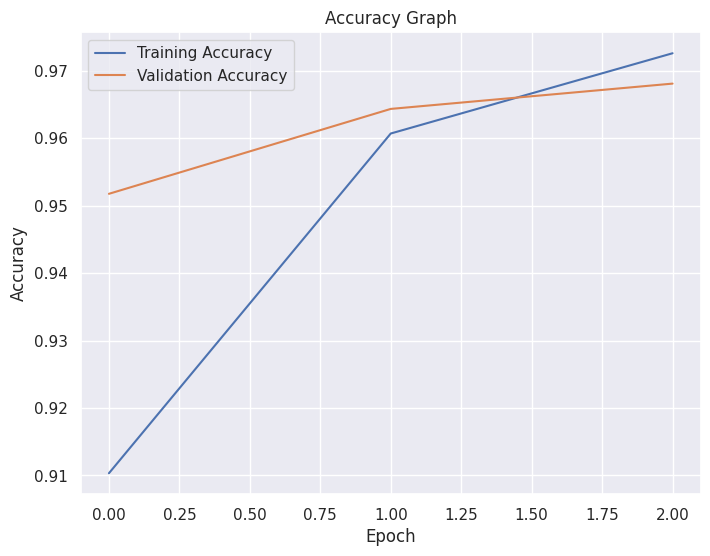

In [ ]:
# Plot accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')
plt.show()
